In [15]:
from helpers import *
import numpy as np
import pandas as pd
import os
import pickle
from LDA_helpers import process_tweets
import re
from pre_process_text import clean
import gensim
from gensim import corpora, models
import itertools
from gensim.utils import lemmatize

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# visualize a whole string
pd.options.display.max_colwidth = 10000


In [2]:
# Load csv file

data = pd.read_csv('../generated/tweets_n_hashtags.csv', index_col = 0)
data.tweet_text = data.tweet_text.apply(lambda x: x[1:-1]).replace("b'", '', regex=True).replace("'", '', regex=True)
data.tweet_text = data.tweet_text.apply(lambda x: x.split(', '))

In [3]:
def tweet_to_topic_id(tweet):
    series = pd.Series(tweet).str.lower()
    data_clean = series.apply(lambda x: re.sub(r'http\S+', '', x)).apply(lambda x: re.sub(r"'|\"|`|:|\?|~|,|\.", '', x))
    lemmatized = data_clean.apply(lambda x: lemmatize(x, min_length=3))
    
    processed = []
    for sentence in lemmatized:
        processed.append([gensim.utils.any2unicode(word) for word in sentence])
    
    return processed


def topic_scores(test, dictionary_list):

    s_sp = calculate_score(test, dictionary_list[0], 1)  
    s_tr = calculate_score(test, dictionary_list[1], 1)
    s_bl = calculate_score(test, dictionary_list[2], 1)
    s_cr = calculate_score(test, dictionary_list[3], 2)
    s_he = calculate_score(test, dictionary_list[4], 3)
    s_gu = calculate_score(test, dictionary_list[5], 1)
    s_hi = calculate_score(test, dictionary_list[6], 1)
    s_en = calculate_score(test, dictionary_list[7], 1)
    s_we = calculate_score(test, dictionary_list[8], 3)
    
    return s_sp, s_tr, s_bl, s_cr, s_he, s_gu, s_hi, s_en, s_we



def extract_topics(s_sp, s_tr, s_bl, s_cr, s_he, s_gu, s_hi, s_en, s_we):
    sport_ = 0
    trump_ = 0
    black_ = 0
    crime_ = 0
    health_ = 0
    gun_ = 0
    hillary_ = 0
    entertainment_ = 0
    weather_ = 0

    tweet_number = 0
    sp_r = []
    sport_score = []
    tr_r = []
    trump_score = []
    bl_r = []
    black_score = []
    cr_r = []
    crime_score = []
    he_r = []
    health_score = []
    gu_r = []
    gun_score = []
    hi_r = []
    hillary_score = []
    en_r = []
    entertainment_score = []
    we_r = []
    weather_score = []

    for sport, trump, black, crime, health, gun, hillary, entertainment, weather in zip(s_sp,
                                                  s_tr,
                                                  s_bl,
                                                  s_cr,
                                                  s_he,
                                                  s_gu,
                                                  s_hi,
                                                  s_en,
                                                  s_we):

        categories = ['sport', 'trump', 'black', 'crime', 'health', 'gun', 'hillary', 'entertainment', 'weather']
        winner = np.max([sport, trump, black, crime, health, gun, hillary, entertainment, weather])
        if winner == sport: 
            sport_ += 1
            sp_r.append(tweet_number)
            sport_score.append(sport)
        elif winner == trump:
            trump_ += 1
            tr_r.append(tweet_number)
            trump_score.append(trump)
        elif winner == black:
            black_ += 1
            bl_r.append(tweet_number)
            black_score.append(black)
        elif winner == crime:
            crime_ += 1
            cr_r.append(tweet_number)
            crime_score.append(crime)
        elif winner == health:
            health_ += 1
            he_r.append(tweet_number)
            health_score.append(health)
        elif winner == gun:
            gun_ += 1
            gu_r.append(tweet_number)
            gun_score.append(gun)
        elif winner == hillary:
            hillary_ += 1
            hi_r.append(tweet_number)
            hillary_score.append(hillary)
        elif winner == entertainment:
            entertainment_ += 1
            en_r.append(tweet_number)
            entertainment_score.append(entertainment)
        elif winner == weather:
            weather_ += 1
            we_r.append(tweet_number)
            weather_score.append(weather)
        tweet_number += 1
    
    return sp_r, tr_r, bl_r, cr_r, he_r, gu_r, hi_r, en_r, we_r


# function for retrieving score
def calculate_score(tweet_data, dictionary, weight):
    score_ = []
    for sentence in tweet_data:
        score = 0
        for word in sentence:
            if word in dictionary:
                score += weight
            else: pass
        score_.append(score)
    return score_


def proportion(related_list, shape):
    sp_p = len(related_list[0])/shape * 100
    tr_p = len(related_list[1])/shape * 100
    bl_p = len(related_list[2])/shape * 100
    cr_p = len(related_list[3])/shape * 100
    he_p = len(related_list[4])/shape * 100
    gu_p = len(related_list[5])/shape * 100
    hi_p = len(related_list[6])/shape * 100
    en_p = len(related_list[7])/shape * 100
    we_p = len(related_list[8])/shape * 100
    return [sp_p, tr_p, bl_p, cr_p, he_p, gu_p, hi_p, en_p, we_p]


def plot_8(proportions, state_name):
    titles = ['Sports', 'Trump', 'Black', 'Crime', 'Health', 'Gun-Related', 'Anti-Hillary', 'Entertainment', 'Weather']
    plt.bar(range(9), proportions)
    plt.title(state_name)
    plt.xticks(np.arange(9), titles, rotation=50)
    plt.show()


# Model for Independent Topic

In [4]:
# SPORTS MODEL

sports = data[data.hashtags == 'Sports']
dictionary_sports = gensim.corpora.Dictionary(sports['tweet_text'])
# create bowcorpus
bow_corpus = [dictionary_sports.doc2bow(doc) for doc in sports['tweet_text']]
# create tf-idf model
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]


# create lda_model'
lda_sports = gensim.models.LdaMulticore(corpus_tfidf, num_topics=1, id2word=dictionary_sports)
dic_sport = set(dict(lda_sports.show_topic(0, 100)).keys())


# TRUMP MODEL
trump = data[data.hashtags == 'Trump Support']
dictionary_trump = gensim.corpora.Dictionary(trump['tweet_text'])
# create bowcorpus
bow_corpus = [dictionary_trump.doc2bow(doc) for doc in trump['tweet_text']]
# create tf-idf model
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]


# create lda_model'
lda_trump = gensim.models.LdaMulticore(corpus_tfidf, num_topics=1, id2word=dictionary_trump)
dic_trump = set(dict(lda_trump.show_topic(0, 100)).keys())

# BLACK MODEL

black = data[data.hashtags == 'Black Support']
dictionary_black = gensim.corpora.Dictionary(black['tweet_text'])
# create bowcorpus
bow_corpus = [dictionary_black.doc2bow(doc) for doc in black['tweet_text']]
# create tf-idf model
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]


# create lda_model'
lda_black = gensim.models.LdaMulticore(corpus_tfidf, num_topics=1, id2word=dictionary_black)
dic_black = set(dict(lda_black.show_topic(0, 100)).keys())


# CRIME MODEL

crime = data[data.hashtags == 'Crime']
dictionary_crime = gensim.corpora.Dictionary(crime['tweet_text'])
# create bowcorpus
bow_corpus = [dictionary_crime.doc2bow(doc) for doc in crime['tweet_text']]
# create tf-idf model
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]


# create lda_model'
lda_crime = gensim.models.LdaMulticore(corpus_tfidf, num_topics=1, id2word=dictionary_crime)
dic_crime = set(dict(lda_crime.show_topic(0, 100)).keys())


# HEALTH MODEL

health = data[data.hashtags == 'Health']
dictionary_health = gensim.corpora.Dictionary(health['tweet_text'])
# create bowcorpus
bow_corpus = [dictionary_crime.doc2bow(doc) for doc in health['tweet_text']]
# create tf-idf model
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]


# create lda_model'
lda_health = gensim.models.LdaMulticore(corpus_tfidf, num_topics=1, id2word=dictionary_health)

dic_health = set(dict(lda_health.show_topic(0, 300)).keys())




# GUN MODEL
gun = data[data.hashtags == 'Gun Related']
dictionary_gun = gensim.corpora.Dictionary(gun['tweet_text'])
# create bowcorpus
bow_corpus = [dictionary_gun.doc2bow(doc) for doc in gun['tweet_text']]
# create tf-idf model
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]


# create lda_model'
lda_gun = gensim.models.LdaMulticore(corpus_tfidf, num_topics=1, id2word=dictionary_gun)
dic_gun = set(dict(lda_gun.show_topic(0, 100)).keys())


# ANTI HILLARY

hillary = data[data.hashtags == 'Anti-Hillary']
dictionary_hillary = gensim.corpora.Dictionary(hillary['tweet_text'])
# create bowcorpus
bow_corpus = [dictionary_hillary.doc2bow(doc) for doc in hillary['tweet_text']]
# create tf-idf model
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]


# create lda_model'
lda_hillary = gensim.models.LdaMulticore(corpus_tfidf, num_topics=1, id2word=dictionary_hillary)

dic_hillary = set(dict(lda_hillary.show_topic(0, 100)).keys())


# ENTERTAINMENT

entertainment = data[data.hashtags == 'Entertainment']
dictionary_entertainment = gensim.corpora.Dictionary(hillary['tweet_text'])
# create bowcorpus
bow_corpus = [dictionary_entertainment.doc2bow(doc) for doc in entertainment['tweet_text']]
# create tf-idf model
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

# create lda_model
lda_entertainment = gensim.models.LdaMulticore(corpus_tfidf, num_topics=1, id2word=dictionary_entertainment)
dic_entertainment = set(dict(lda_entertainment.show_topic(0,100)).keys())


# Weather related



/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

In [5]:
dic_weather = set(['air/NN', 'barometer/NN','blizzard/NN','celsius/NN','chill/NN','cirrus/NN','cloud/NN',
           'clouds/NN','cloudy/NN','cold/NN','cyclone/NN','degree/NN','dew/NN','drizzle/NN',
           'dry/NN','fahrenheit/NN','flood/NN','fog/NN','forecast/NN','freeze/NN','frost/NN',
           'hail/NN','heat/NN','hot/NN','humidity/NN','hurricane/NN','ice/NN','lightning/NN', 'matthew/NN',
           'meteorology/NN','moon/NN','precipitation/NN','pressure/NN','radar/NN','rain/NN','rainstorm/NN',
           'rainbow/NN','rainy/NN','sky/NN','sleet/NN','snow/NN','snowstorm/NN','snowy/NN',
           'storm/NN','sun/NN','sunny/NN','temperature/NN','thermometer/NN','thunder/NN','thunderstorm/NN',
           'tornado/NN','tsunami/NN','typhoon/NN','warm/NN','weather/NN','wind/NN','windy/NN'])

In [6]:
dictionary_list = [dic_sport, dic_trump, dic_black, dic_crime, dic_health, dic_gun,
                  dic_hillary, dic_entertainment, dic_weather]

# Testing

In [7]:
tweet = ['sports our fans thanks our love for football',
         'anyone watching baseball?', 
         'dont go for hillary, she sucks',
         'trump is a great guy, would make an excellent president',
         'why do black people get targetted by the police?',
         'everyone is racist here',
         'some guy got arrested yesterday',
         'there was a shooting at a school',
         'its important to go to the gym and stay healthy',
         'go to see your doctor if you have fever. you might have measles',
         'got to keep your rifles! Thats America',
         'support our army',
         'hurricane matthew is destroying everything',
         'You have to listen to this new album! So fun']

test = tweet_to_topic_id(tweet)


/anaconda3/envs/ada/lib/python3.6/site-packages/Pattern-3.6-py3.6.egg/pattern/text/__init__.py:625: DeprecationWarning: generator '_read' raised StopIteration
  dict.update(self, (x.split(" ")[:2] for x in _read(self._path) if len(x.split(" ")) > 1))
/anaconda3/envs/ada/lib/python3.6/site-packages/Pattern-3.6-py3.6.egg/pattern/text/__init__.py:959: DeprecationWarning: generator '_read' raised StopIteration
  for x in _read(self.path):
/anaconda3/envs/ada/lib/python3.6/site-packages/Pattern-3.6-py3.6.egg/pattern/text/__init__.py:2127: DeprecationWarning: generator '_read' raised StopIteration
  for v in _read(self._path):


In [8]:
s_sp, s_tr, s_bl, s_cr, s_he, s_gu, s_hi, s_en, s_we = topic_scores(test, dictionary_list)

sp_r, tr_r, bl_r, cr_r, he_r, gu_r, hi_r, en_r, we_r = extract_topics(s_sp, s_tr, 
                                                                      s_bl, s_cr,
                                                                      s_he, s_gu,
                                                                      s_hi, s_en, s_we)

related_list = [sp_r, tr_r, bl_r, cr_r, he_r, gu_r, hi_r, en_r, we_r ]

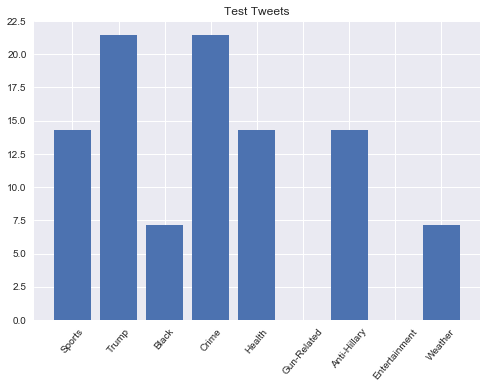

In [16]:
proportions = proportion(related_list, len(test))
plot_8(proportions, 'Test Tweets')

# Loading Dataset

In [10]:
from helpers import *
cols_to_extract = [0,1,2,3,4,5,7,8,9,10,11,13,14]
tweets1 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_1.csv', usecols=cols_to_extract)
tweets2 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_2.csv', usecols=cols_to_extract)
tweets3 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_3.csv', usecols=cols_to_extract)
tweets4 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_4.csv', usecols=cols_to_extract) 
tweets5 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_5.csv', usecols=cols_to_extract)
tweets6 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_6.csv', usecols=cols_to_extract)
tweets7 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_7.csv', usecols=cols_to_extract) 
tweets8 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_8.csv', usecols=cols_to_extract) 
tweets9 = pd.read_csv(access_folder('data') + 'IRAhandle_tweets_9.csv', usecols=cols_to_extract)

tweets = pd.concat([tweets1,tweets2,tweets3,tweets4,tweets5,tweets6,tweets7,tweets8,tweets9], axis=0)
del tweets1,tweets2,tweets3,tweets4,tweets5,tweets6,tweets7,tweets8,tweets9

In [11]:
#complete post_type column with normal tweet category
tweets.post_type.fillna('TWEET', inplace=True)

tweets['content'] = tweets.content.astype(str)

tweets[['external_author_id', 'author', 'region', 'language', 'post_type', 'account_type', 'retweet', 'account_category']] = \
tweets[['external_author_id', 'author', 'region', 'language', 'post_type', 'account_type', 'retweet', 'account_category']].astype('category')

tweets['publish_date'] = pd.to_datetime(tweets['publish_date'], format='%m/%d/%Y %H:%M')

tweets.dtypes

external_author_id          category
author                      category
content                       object
region                      category
language                    category
publish_date          datetime64[ns]
following                      int64
followers                      int64
updates                        int64
post_type                   category
account_type                category
retweet                     category
account_category            category
dtype: object

In [17]:
tweets_processed = tweets[(tweets.publish_date < '2016-11-10')
                          & (tweets.publish_date > '2016-10-01')
                          & (tweets.language == 'English')][['content', 'followers', 'account_category']]

In [18]:
tweets_processed.content = tweets_processed.content.apply(lambda x:
                                                          re.sub(r'http\S+', '', x)
                                                         ).apply(lambda x
                                                                 :re.sub(r"'|\"|`|:|\?|~|,|\.", '', x))




In [19]:
test = tweet_to_topic_id(tweets_processed.content.values)

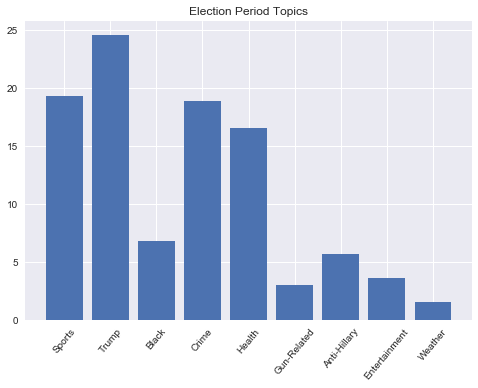

In [20]:
s_sp, s_tr, s_bl, s_cr, s_he, s_gu, s_hi, s_en, s_we = topic_scores(test, dictionary_list)

sp_r, tr_r, bl_r, cr_r, he_r, gu_r, hi_r, en_r, we_r = extract_topics(s_sp, s_tr, 
                                                                      s_bl, s_cr,
                                                                      s_he, s_gu,
                                                                      s_hi, s_en, s_we)

related_list = [sp_r, tr_r, bl_r, cr_r, he_r, gu_r, hi_r, en_r, we_r ]

proportions = proportion(related_list, len(test))
plot_8(proportions, 'Election Period Topics')

In [32]:
tweets_processed.shape

(136799, 3)

# Topics and Swing States

In [29]:
# List of swing states
swing_states = ['Colorado|colorado', 'Florida|florida|Miami|miami|Orlando|orlando', 'Iowa|iowa',
                'Michigan|michigan', 'Nevada|nevada', 
                'New Hampshire|new hampshire', 'North Carolina|north carolina', 
                'Ohio|ohio','Pennsylvania|pennsylvania','Virginia|virginia', 'Wisconsin|wisconsin']

swing_state_proportions = []

for state in swing_states:
    filtered = tweets_processed[tweets_processed.content.str.contains(state)].copy()
    print(filtered.shape)
    test = tweet_to_topic_id(filtered.content.values)

    s_sp, s_tr, s_bl, s_cr, s_he, s_gu, s_hi, s_en, s_we = topic_scores(test, dictionary_list)

    sp_r, tr_r, bl_r, cr_r, he_r, gu_r, hi_r, en_r, we_r = extract_topics(s_sp, s_tr, 
                                                                      s_bl, s_cr,
                                                                      s_he, s_gu,
                                                                      s_hi, s_en, s_we)

    related_list = [sp_r, tr_r, bl_r, cr_r, he_r, gu_r, hi_r, en_r, we_r ]

    proportions = proportion(related_list, len(test))
    swing_state_proportions.append(proportions)

(120, 3)
(1125, 3)
(139, 3)
(247, 3)
(123, 3)
(53, 3)
(221, 3)
(392, 3)
(183, 3)
(209, 3)
(112, 3)


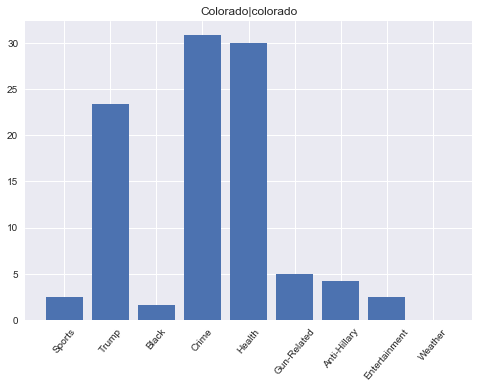

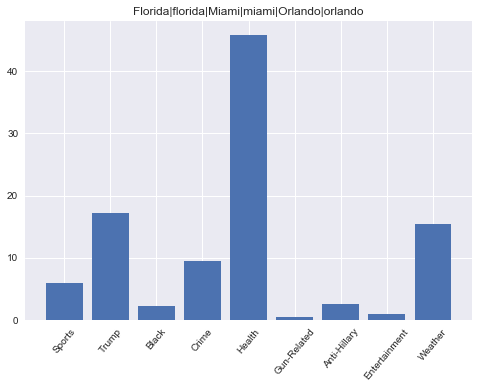

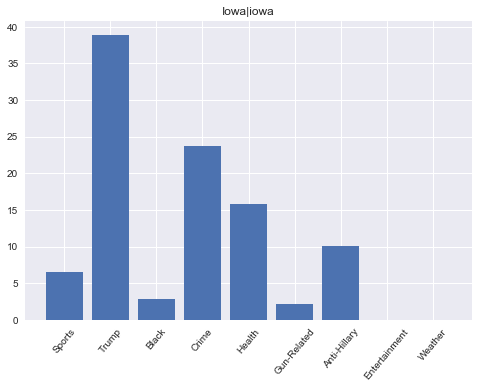

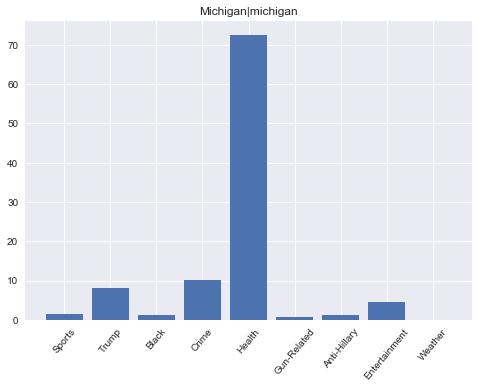

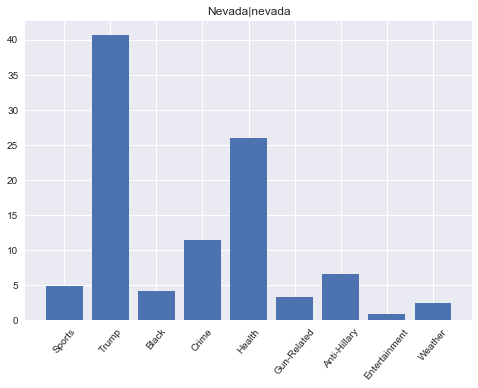

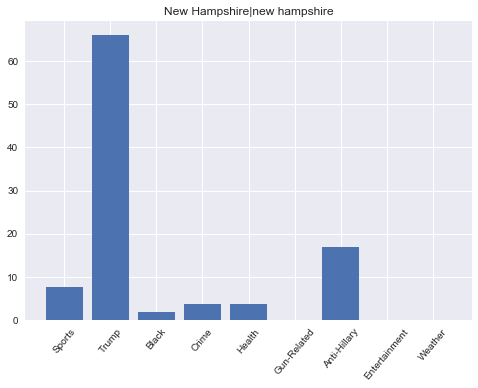

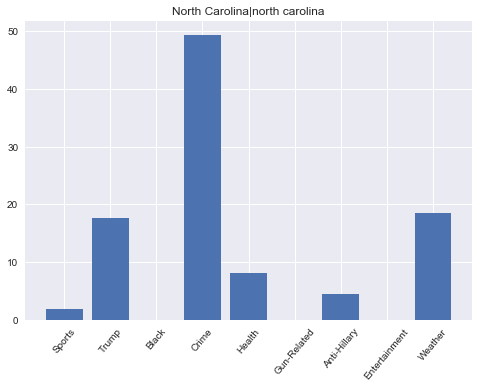

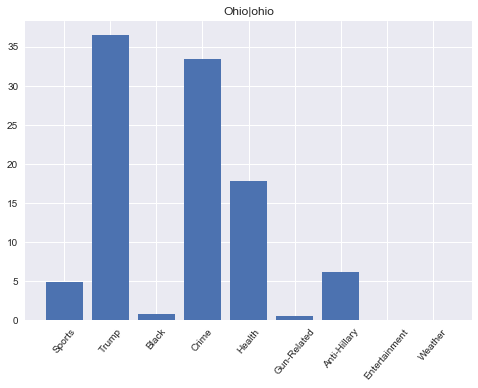

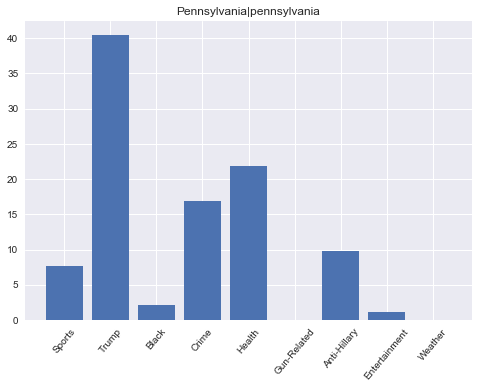

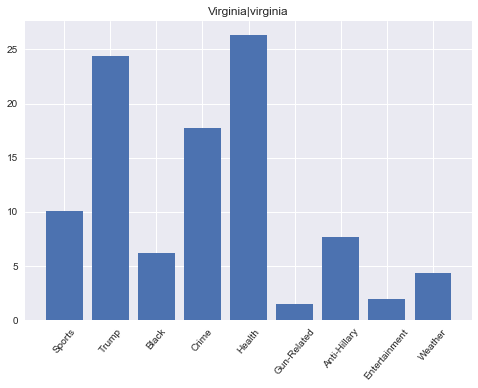

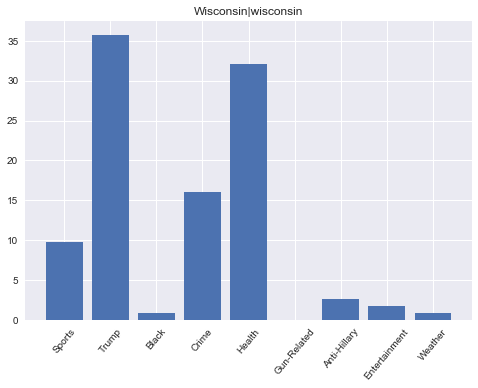

In [31]:
for idx, state in enumerate(swing_states):
    plot_8(swing_state_proportions[idx], state)

In [ ]:

florida = tweets_processed[tweets_processed.content.str.contains('Florida|florida')]

In [ ]:
test = tweet_to_topic_id(florida.content.values)

s_sp, s_tr, s_bl, s_cr, s_he, s_gu, s_hi, s_en, s_we = topic_scores(test, dictionary_list)

sp_r, tr_r, bl_r, cr_r, he_r, gu_r, hi_r, en_r, we_r = extract_topics(s_sp, s_tr, 
                                                                      s_bl, s_cr,
                                                                      s_he, s_gu,
                                                                      s_hi, s_en, s_we)

related_list = [sp_r, tr_r, bl_r, cr_r, he_r, gu_r, hi_r, en_r, we_r ]

proportions = proportion(related_list, len(test))
plot_8(proportions, 'Florida')

In [ ]:
ohio = tweets_processed[tweets_processed.content.str.contains('Ohio|ohio')]

In [ ]:
test = tweet_to_topic_id(ohio.content.values)

s_sp, s_tr, s_bl, s_cr, s_he, s_gu, s_hi, s_en, s_we = topic_scores(test, dictionary_list)

sp_r, tr_r, bl_r, cr_r, he_r, gu_r, hi_r, en_r, we_r = extract_topics(s_sp, s_tr, 
                                                                      s_bl, s_cr,
                                                                      s_he, s_gu,
                                                                      s_hi, s_en, s_we)

related_list = [sp_r, tr_r, bl_r, cr_r, he_r, gu_r, hi_r, en_r, we_r ]

proportions = proportion(related_list, len(test))
plot_8(proportions, 'Ohio')

In [ ]:
texas = tweets_processed[tweets_processed.content.str.contains('Texas|texas')]

In [ ]:
test = tweet_to_topic_id(texas.content.values)

s_sp, s_tr, s_bl, s_cr, s_he, s_gu, s_hi, s_en, s_we = topic_scores(test, dictionary_list)

sp_r, tr_r, bl_r, cr_r, he_r, gu_r, hi_r, en_r, we_r = extract_topics(s_sp, s_tr, 
                                                                      s_bl, s_cr,
                                                                      s_he, s_gu,
                                                                      s_hi, s_en, s_we)

related_list = [sp_r, tr_r, bl_r, cr_r, he_r, gu_r, hi_r, en_r, we_r ]

proportions = proportion(related_list, len(test))
plot_8(proportions, 'Texas')